In [21]:
# ===== Loading Packages =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

In [22]:
# ===== Preprocessing Again =====

train_df = pd.read_csv(r'C:/Users/conre/OneDrive/Desktop/Coding Folder/.csv files/project_adult.csv')
valid_df = pd.read_csv(r'C:/Users/conre/OneDrive/Desktop/Coding Folder/.csv files/project_validation_inputs.csv')

train_df = train_df.replace("?", np.nan)
valid_df = valid_df.replace("?", np.nan)

y_raw = train_df["income"]
X_train_raw = train_df.drop(columns=["income"])
X_valid_raw = valid_df.copy()

numeric_cols = X_train_raw.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X_train_raw.select_dtypes(include=["object","category","bool"]).columns.tolist()

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler(with_mean=False))
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])


pre = ColumnTransformer([
    ("num", num_pipe, numeric_cols),
    ("cat", cat_pipe, categorical_cols)
], sparse_threshold=1.0, remainder="drop")

X_train_final = pre.fit_transform(X_train_raw)
X_valid_final = pre.transform(X_valid_raw)

if not sp.issparse(X_train_final): X_train_final = sp.csr_matrix(X_train_final)
if not sp.issparse(X_valid_final): X_valid_final = sp.csr_matrix(X_valid_final)


In [23]:
# ===== Shared hold-out split for confusion matrices =====
from sklearn.model_selection import train_test_split
random_state = 42
X_tr, X_te, y_tr, y_te = train_test_split(
    X_train_final, y_raw, test_size=0.30, stratify=y_raw, random_state=random_state
)
labels = ["<=50K", ">50K"]


[LogReg] C=0.01   | 5-fold CV Acc: 0.8471 ± 0.0036
[LogReg] C=0.1    | 5-fold CV Acc: 0.8501 ± 0.0034
[LogReg] C=1.0    | 5-fold CV Acc: 0.8495 ± 0.0037
[LogReg] C=10.0   | 5-fold CV Acc: 0.8494 ± 0.0034
[LogReg] C=100.0  | 5-fold CV Acc: 0.8492 ± 0.0035

[LogReg] Selected C: 0.1 | 5-fold CV Accuracy: 0.8501 ± 0.0034

[LogReg][Hold-out] Accuracy (for CM only): 0.8468330134357006
              precision    recall  f1-score   support

       <=50K      0.872     0.936     0.903      5934
        >50K      0.736     0.567     0.640      1881

    accuracy                          0.847      7815
   macro avg      0.804     0.751     0.772      7815
weighted avg      0.839     0.847     0.840      7815



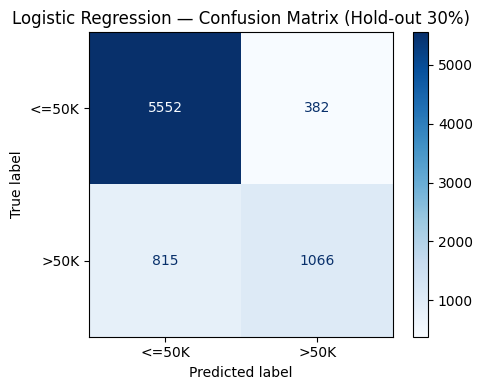

In [24]:
# ===== Part 3a — Logistic Regression =====
random_state = 42
C_grid = [0.01, 0.1, 1.0, 10.0, 100.0]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

cv_results = []
for C in C_grid:
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("logreg", LogisticRegression(penalty="l2", C=C, solver="lbfgs", max_iter=2000, random_state=random_state))
    ])
    scores = cross_val_score(pipe, X_train_final, y_raw, cv=cv, scoring="accuracy")
    mean_, std_ = scores.mean(), scores.std()
    cv_results.append((C, mean_, std_))
    print(f"[LogReg] C={C:<6} | 5-fold CV Acc: {mean_:.4f} ± {std_:.4f}")

best_C = max(cv_results, key=lambda x: x[1])[0]
best_mean = [m for c,m,s in cv_results if c == best_C][0]
best_std  = [s for c,m,s in cv_results if c == best_C][0]
print(f"\n[LogReg] Selected C: {best_C} | 5-fold CV Accuracy: {best_mean:.4f} ± {best_std:.4f}")

logreg_best = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("logreg", LogisticRegression(penalty="l2", C=best_C, solver="lbfgs", max_iter=2000, random_state=random_state))
])
logreg_best.fit(X_train_final, y_raw)

logreg_hold = clone(logreg_best)
logreg_hold.fit(X_tr, y_tr)
y_pred_hold = logreg_hold.predict(X_te)
print("\n[LogReg][Hold-out] Accuracy (for CM only):", accuracy_score(y_te, y_pred_hold))
print(classification_report(y_te, y_pred_hold, digits=3))
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_te, y_pred_hold, labels=labels, display_labels=labels, cmap="Blues", values_format="d", ax=ax)
ax.set_title("Logistic Regression — Confusion Matrix (Hold-out 30%)")
plt.tight_layout(); plt.show()


[SVM]   C=0.01   | 5-fold CV Acc: 0.8511 ± 0.0032
[SVM]   C=0.1    | 5-fold CV Acc: 0.8500 ± 0.0034
[SVM]   C=1.0    | 5-fold CV Acc: 0.8496 ± 0.0037
[SVM]   C=10.0   | 5-fold CV Acc: 0.8497 ± 0.0037
[SVM]   C=100.0  | 5-fold CV Acc: 0.8497 ± 0.0034

[SVM]   Selected C: 0.01 | 5-fold CV Accuracy: 0.8511 ± 0.0032

[SVM][Hold-out] Accuracy (for CM only): 0.8488803582853487
              precision    recall  f1-score   support

       <=50K      0.871     0.940     0.904      5934
        >50K      0.748     0.562     0.642      1881

    accuracy                          0.849      7815
   macro avg      0.809     0.751     0.773      7815
weighted avg      0.841     0.849     0.841      7815



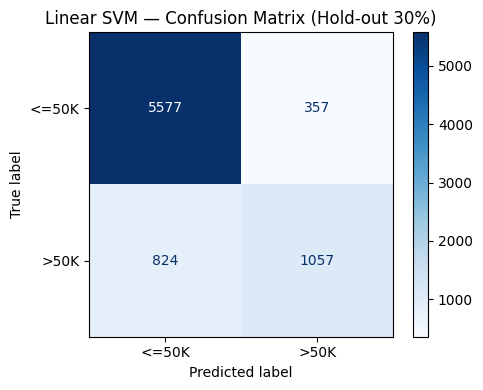

In [25]:
# ===== Part 3b — Linear SVM =====
random_state = 42
C_grid = [0.01, 0.1, 1.0, 10.0, 100.0]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

cv_results_svm = []
for C in C_grid:
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("svm", LinearSVC(C=C, loss="squared_hinge", dual=False, max_iter=20000, tol=1e-3))
    ])
    scores = cross_val_score(pipe, X_train_final, y_raw, cv=cv, scoring="accuracy")
    mean_, std_ = scores.mean(), scores.std()
    cv_results_svm.append((C, mean_, std_))
    print(f"[SVM]   C={C:<6} | 5-fold CV Acc: {mean_:.4f} ± {std_:.4f}")

best_C_svm = max(cv_results_svm, key=lambda x: x[1])[0]
best_mean_svm = [m for c,m,s in cv_results_svm if c == best_C_svm][0]
best_std_svm  = [s for c,m,s in cv_results_svm if c == best_C_svm][0]
print(f"\n[SVM]   Selected C: {best_C_svm} | 5-fold CV Accuracy: {best_mean_svm:.4f} ± {best_std_svm:.4f}")

svm_best = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("svm", LinearSVC(C=best_C_svm, loss="squared_hinge", dual=False, max_iter=20000, tol=1e-3))
])
svm_best.fit(X_train_final, y_raw)

svm_hold = clone(svm_best)
svm_hold.fit(X_tr, y_tr)
y_pred_svm_hold = svm_hold.predict(X_te)
print("\n[SVM][Hold-out] Accuracy (for CM only):", accuracy_score(y_te, y_pred_svm_hold))
print(classification_report(y_te, y_pred_svm_hold, digits=3))
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_te, y_pred_svm_hold, labels=labels, display_labels=labels, cmap="Blues", values_format="d", ax=ax)
ax.set_title("Linear SVM — Confusion Matrix (Hold-out 30%)")
plt.tight_layout(); plt.show()


In [26]:
# ===== Part 3c — Predict validation inputs and save CSVs =====
import pandas as pd
logreg_valid_preds = logreg_best.predict(X_valid_final)
svm_valid_preds    = svm_best.predict(X_valid_final)
pd.DataFrame({"prediction": logreg_valid_preds}).to_csv("Group_7_LogisticRegression_PredictedOutputs.csv", index=False)
pd.DataFrame({"prediction": svm_valid_preds}).to_csv("Group_7_SVM_PredictedOutputs.csv", index=False)


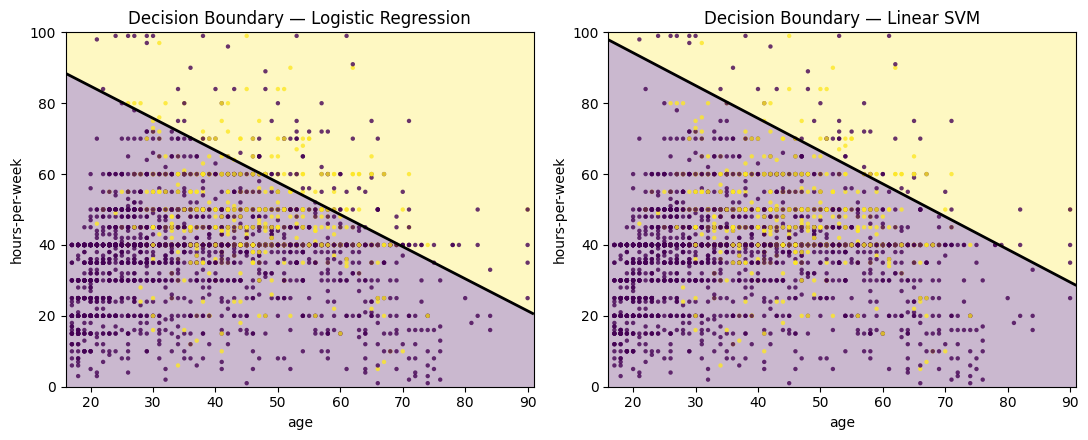

In [27]:
# ===== Part 3d — Decision Boundaries =====

# pick a sensible pair if present; else first two numeric
candidates = [("age", "hours-per-week"), ("education-num", "hours-per-week"), ("age", "education-num")]
use_pair = None
for a, b in candidates:
    if a in train_df.columns and b in train_df.columns:
        use_pair = (a, b); break
if use_pair is None:
    use_pair = (numeric_cols[0], numeric_cols[1])

feat1, feat2 = use_pair
X2 = train_df[[feat1, feat2]].values
y2 = y_raw.values
y2_bin = (y2 == ">50K").astype(int)

# pipelines using tuned C values
logreg_2d = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("clf", LogisticRegression(C=best_C, penalty="l2", solver="lbfgs", max_iter=2000, random_state=42))
])
svm_2d = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("clf", LinearSVC(C=best_C_svm, loss="squared_hinge", dual=False, max_iter=20000, tol=1e-3))
])

logreg_2d.fit(X2, y2)
svm_2d.fit(X2, y2)

# smooth background grid covering full plot range
x_min = X2[:, 0].min() - 1
x_max = X2[:, 0].max() + 1
y_min = X2[:, 1].min() - 1
y_max = X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 350),
                     np.linspace(y_min, y_max, 350))
grid = np.c_[xx.ravel(), yy.ravel()]


# predictions for background shading (convert labels -> ints)
log_pred_labels = logreg_2d.predict(grid).reshape(xx.shape)   # strings
svm_pred_labels = svm_2d.predict(grid).reshape(xx.shape)      # strings

# map to 0/1 so contourf gets numeric arrays
log_pred = (log_pred_labels == ">50K").astype(int)
svm_pred = (svm_pred_labels == ">50K").astype(int)

# also get proba/margin just for drawing a crisp boundary line
log_proba = logreg_2d.predict_proba(grid)[:, 1].reshape(xx.shape)   # P(>50K)
svm_margin = svm_2d.decision_function(grid).reshape(xx.shape)       # >0 => >50K

# ---- plotting
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))

# Logistic Regression background + boundary + points
axes[0].contourf(xx, yy, log_pred, levels=[-0.5, 0.5, 1.5], alpha=0.28, cmap=cmap_bg)
axes[0].contour(xx, yy, log_proba, levels=[0.5], colors="k", linewidths=2)
axes[0].scatter(X2[idx, 0], X2[idx, 1], c=y2_bin[idx], s=10, alpha=0.8, linewidths=0, cmap=cmap_bg)
axes[0].set_xlabel(feat1); axes[0].set_ylabel(feat2)
axes[0].set_title("Decision Boundary — Logistic Regression")

# Linear SVM background + boundary + points
axes[1].contourf(xx, yy, svm_pred, levels=[-0.5, 0.5, 1.5], alpha=0.28, cmap=cmap_bg)
axes[1].contour(xx, yy, svm_margin, levels=[0.0], colors="k", linewidths=2)
axes[1].scatter(X2[idx, 0], X2[idx, 1], c=y2_bin[idx], s=10, alpha=0.8, linewidths=0, cmap=cmap_bg)
axes[1].set_xlabel(feat1); axes[1].set_ylabel(feat2)
axes[1].set_title("Decision Boundary — Linear SVM")

plt.tight_layout(); plt.show()



**Logistic Regression:**  
The boundary line shows where the model predicts a 50% chance of earning `>50K`.  
Points above the line (yellow region) are classified as `>50K`, while those below the line (purple region) are classified as `<=50K`.  
We see some overlap—yellow points in purple space and vice versa—showing misclassifications.  
This happens because the dataset is imbalanced, with more people earning `<=50K`, and because age and hours-per-week alone cannot perfectly separate the classes.  

**Linear SVM:**  
The SVM decision boundary is very similar to logistic regression’s, but it shifts slightly because the SVM maximizes the margin between classes using support vectors (the critical edge cases).  
The overlap between regions and actual points again highlights that age and hours-per-week are not sufficient to perfectly predict income.  


Overall, both models behave consistently, showing similar splits.  
They capture general trends—older individuals working longer hours are more likely to earn `>50K`—but the misclassifications make it clear that additional features are necessary to improve accuracy.  

